In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import mesaPlot as mp
import pandas as pd
from scipy.interpolate import griddata
from custom_mpl_settings import load_mpl_rc
load_mpl_rc()
cmap = plt.get_cmap('viridis')
m = mp.MESA()
from functions import add_Teff, remove_incomplete_tracks_GB
from mint_general_interpolation_grid_builder.MINT.config.table_columns import table_columns
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.GB_table_builder import RedGiantBranchTableBuilder

def get_convective_envelope_mass_fraction(x):
    if x['HELIUM_CORE_MASS_FRACTION'] == 1:
        f_conv = 0
    elif x['CONVECTIVE_ENVELOPE_MASS_TOP_FRACTION'] > 0.99:
        f_conv = x['CONVECTIVE_ENVELOPE_MASS_FRACTION']/(1-x['HELIUM_CORE_MASS_FRACTION'])
    else:
        f_conv = 0
    return f_conv

def remove_tams_rejuvenation(df):
    for M in df['MASS'].unique():
        min_degen = -10
        for Mi in np.sort(df[df['MASS']==M]['INITIAL_MASS'].unique())[::-1]:
            del_mask =  (df['INITIAL_MASS']==Mi) & (df['MASS']==M) & (df['CENTRAL_DEGENERACY']<min_degen)
            df = df[~del_mask]
            min_degen = np.min(df[(df['INITIAL_MASS']==Mi) & (df['MASS']==M)]['CENTRAL_DEGENERACY'])
    return df

settings = {
    **table_columns,
    'grid_directory':f'/Users/natalierees/MINT_grids_23051/Z0.02/GB',
    'metallicity':0.02,
    'num_processes':4
}
tester = RedGiantBranchTableBuilder(settings=settings)


evol_phase = 'GB'
metallicity = 0.02
table_name = "tracks_Z%7.2e_%s.csv" %(float(metallicity),evol_phase)
table_filepath = os.path.join(f'/Users/natalierees/MINT_grids_23051/Z{metallicity}/{evol_phase}',table_name)
df = pd.read_csv(table_filepath,index_col=[0])
df = add_Teff(df)
# df['f_conv'] = df['CONVECTIVE_ENVELOPE_MASS_FRACTION']/(1-df['HELIUM_CORE_MASS_FRACTION'])
df['f_conv'] = df.apply(lambda x:get_convective_envelope_mass_fraction(x),axis=1)
df['HELIUM_CORE_MASS'] = df['HELIUM_CORE_MASS_FRACTION']*df["MASS"]
df = df[df['WARNING_FLAG']==0]
df['LOG_MAX_TEMPERATURE'] = df['CHEBYSHEV_TEMPERATURE'].apply(lambda x: np.log10(np.max([float(v) for v in x[1:-1].split()])))
Xc_TAMS = 1e-6
# remove tracks that don't ignite helium
df = df[df.groupby(['MASS', 'INITIAL_MASS'])['HELIUM_IGNITED_FLAG'].transform('max') == 1]
# remove tams rejuvenation
df = remove_tams_rejuvenation(df)
# df = df[df['MASS']<100]
df_sse = df[df['INITIAL_MASS']==df['MASS']]
print(df.info())

Building a grid with (X_0, Y_0, Z_0)=(0.7, 0.28, 0.02)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74006 entries, 1 to 150
Data columns (total 55 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   MASS                                         74006 non-null  float64
 1   CENTRAL_DEGENERACY                           74006 non-null  float64
 2   HELIUM_CORE_MASS_FRACTION                    74006 non-null  float64
 3   RADIUS                                       74006 non-null  float64
 4   LUMINOSITY                                   74006 non-null  float64
 5   LUMINOSITY_DIV_EDDINGTON_LUMINOSITY          74006 non-null  float64
 6   NEUTRINO_LUMINOSITY                          74006 non-null  float64
 7   HELIUM_LUMINOSITY                            74006 non-null  float64
 8   AGE                                          74006 non-null  float64
 9   AGE_FRACTION       

In [108]:
np.logspace(np.log10(0.08), np.log10(1000), num=200)

array([8.00000000e-02, 8.38836799e-02, 8.79558970e-02, 9.22258039e-02,
       9.67029977e-02, 1.01397541e-01, 1.06319986e-01, 1.11481396e-01,
       1.16893372e-01, 1.22568078e-01, 1.28518267e-01, 1.34757315e-01,
       1.41299244e-01, 1.48158757e-01, 1.55351271e-01, 1.62892954e-01,
       1.70800755e-01, 1.79092449e-01, 1.87786671e-01, 1.96902962e-01,
       2.06461813e-01, 2.16484708e-01, 2.26994175e-01, 2.38013834e-01,
       2.49568453e-01, 2.61684003e-01, 2.74387714e-01, 2.87708140e-01,
       3.01675219e-01, 3.16320344e-01, 3.31676431e-01, 3.47777995e-01,
       3.64661225e-01, 3.82364069e-01, 4.00926315e-01, 4.20389683e-01,
       4.40797921e-01, 4.62196896e-01, 4.84634706e-01, 5.08161782e-01,
       5.32831004e-01, 5.58697817e-01, 5.85820361e-01, 6.14259596e-01,
       6.44079442e-01, 6.75346922e-01, 7.08132313e-01, 7.42509303e-01,
       7.78555159e-01, 8.16350898e-01, 8.55981468e-01, 8.97535943e-01,
       9.41107722e-01, 9.86794737e-01, 1.03469967e+00, 1.08493020e+00,
      

In [11]:
df['MASS'].unique()

array([ 0.33,  0.38,  0.43,  0.48,  0.53,  0.63,  0.73,  0.83,  1.03,
        1.18,  1.33,  1.48,  1.63,  1.83,  2.03,  2.28,  2.53,  2.91,
        3.29,  3.72,  4.2 ,  4.74,  5.35,  6.04,  6.83,  7.71,  8.71,
        9.83, 11.1 , 12.5 , 14.2 , 16.  , 18.1 , 20.4 , 23.  , 26.  ,
       29.4 , 33.2 ])

Starting MS: MASS: 1.0, CENTRAL_HYDROGEN: 0.6985
Finished MS: MASS: 1.0, CENTRAL_HYDROGEN: 8.183846370005971e-07
Starting GB: MASS: 1.0, CENTRAL_DEGENERACY: -0.3231339517772993, HELIUM_CORE_MASS_FRACTION: 0.026873265620994388
Finished GB: MASS: 1.0, CENTRAL_DEGENERACY: 35.71578298620797, HELIUM_CORE_MASS_FRACTION: 0.4737150063992388


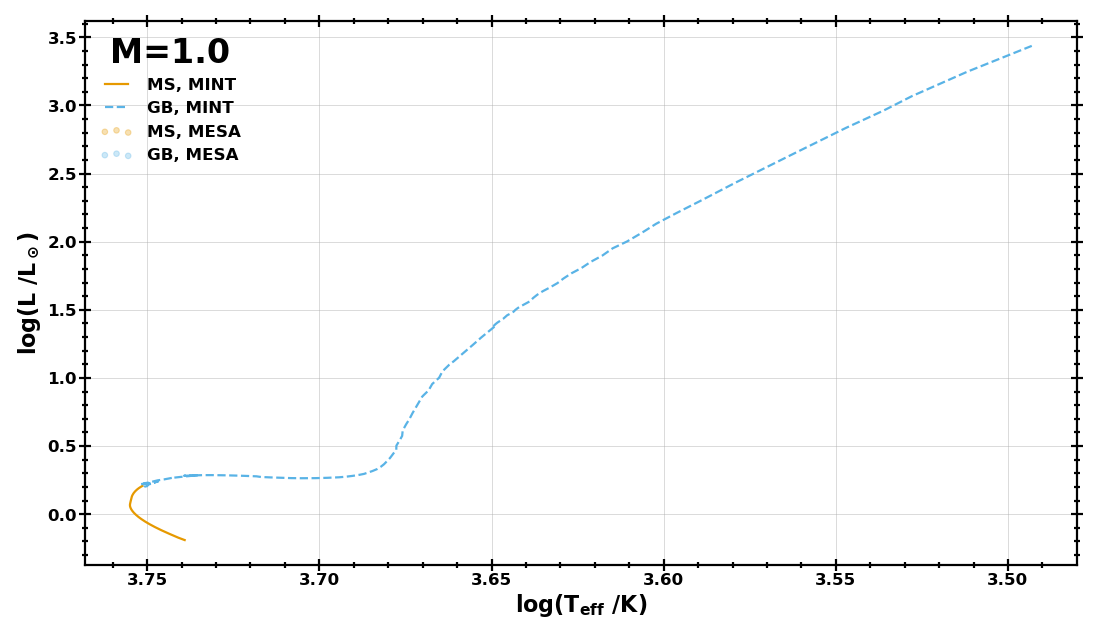

In [109]:
M=1.0
tester.integrate_CME(mass=M)
fig,ax=plt.subplots()
ax = tester.plot_HR_SSE(tester.df_MESA_dict, tester.df_evol_dict, ax, M)
plt.show()

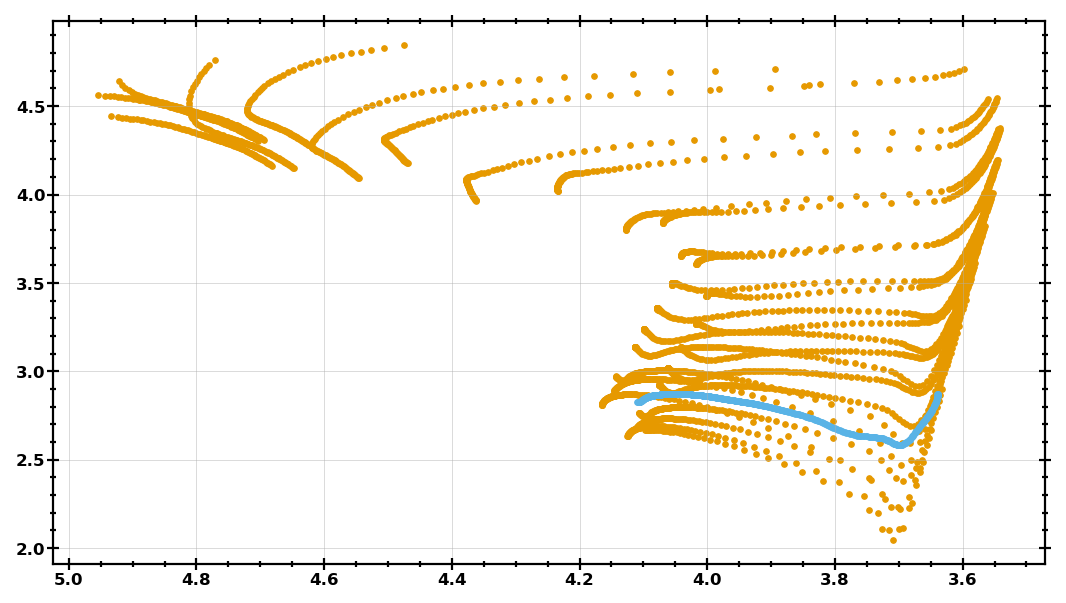

In [32]:
fig,ax=plt.subplots()
ax.scatter(tester.df_MESA_dict['GB']['LOG_EFFECTIVE_TEMPERATURE'],tester.df_MESA_dict['GB']['LOG_LUMINOSITY'])
ax.scatter(tester.df_evol_dict['GB']['LOG_EFFECTIVE_TEMPERATURE'],tester.df_evol_dict['GB']['LOG_LUMINOSITY'])
ax.invert_xaxis()

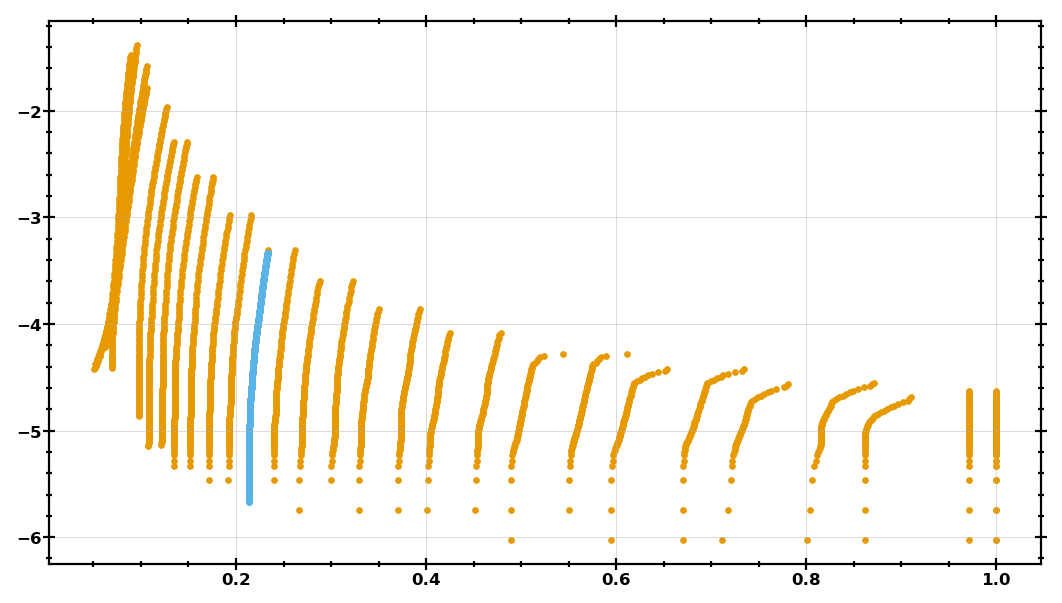

In [23]:
fig,ax=plt.subplots()
ax.scatter(tester.df_MESA_dict['GB']['HELIUM_CORE_MASS_FRACTION'],tester.df_MESA_dict['GB']['CENTRAL_DEGENERACY'])
ax.scatter(tester.df_evol_dict['GB']['HELIUM_CORE_MASS_FRACTION'],tester.df_evol_dict['GB']['CENTRAL_DEGENERACY'])


Starting MS: MASS: 1.0, CENTRAL_HYDROGEN: 0.6985
Finished MS: MASS: 1.0, CENTRAL_HYDROGEN: 8.183846370005971e-07
Starting GB: MASS: 1.0, CENTRAL_DEGENERACY: -0.3231339517772993, HELIUM_CORE_MASS_FRACTION: 0.026873265620994388
Finished GB: MASS: 1.0, CENTRAL_DEGENERACY: 35.71578298620797, HELIUM_CORE_MASS_FRACTION: 0.4737150063992388
Starting MS: MASS: 2.0, CENTRAL_HYDROGEN: 0.6985
Finished MS: MASS: 2.0, CENTRAL_HYDROGEN: -3.2371151140713713e-06
Starting GB: MASS: 2.0, CENTRAL_DEGENERACY: -1.6189934905095984, HELIUM_CORE_MASS_FRACTION: 0.06522413046903011
Finished GB: MASS: 2.0, CENTRAL_DEGENERACY: 16.548635058457098, HELIUM_CORE_MASS_FRACTION: 0.20773295498096578
Starting MS: MASS: 4.0, CENTRAL_HYDROGEN: 0.6985
Finished MS: MASS: 4.0, CENTRAL_HYDROGEN: -1.3131589678049032e-05
Starting GB: MASS: 4.0, CENTRAL_DEGENERACY: -2.920667588395983, HELIUM_CORE_MASS_FRACTION: 0.07790876522650322
Finished GB: MASS: 4.0, CENTRAL_DEGENERACY: 0.7139611451643993, HELIUM_CORE_MASS_FRACTION: 0.12742126

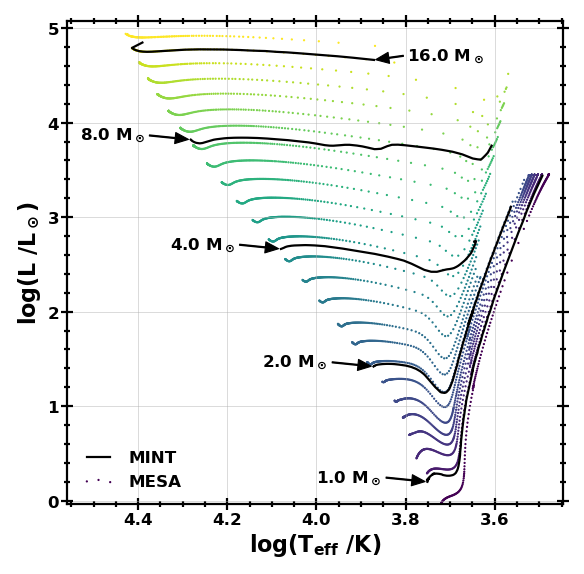

In [86]:
fig,ax = plt.subplots(figsize=(8,8))

tester.stopping_conditions_dict = {
    "MS": {"CENTRAL_HYDROGEN": {"type": "decreasing", "critical_value": 1e-6,}},
    "GB": {
        "HELIUM_IGNITED_FLAG": {
            "type": "increasing",
            "critical_value": 0.2,
        }
    },
    "CHeB": {"CENTRAL_HELIUM": {"type": "decreasing", "critical_value": 1e-4,}},
    "EAGB": {
        "CENTRAL_NEON": {"type": "decreasing", "critical_value": 0.01,},
        "ONSET_THERMAL_PULSES_FLAG": {"type": "boolean", "critical_value": 1,},
        "INTERSHELL_MASS": {"type": "decreasing", "critical_value": 0.01,},
    },
}

mass_list = [1.0,2.0,4.0,8.0,16.0]
# mass_list = [1.03,2.03,4.2,8.71,16.0]

for M in mass_list[:]:
    tester.integrate_CME(mass=M)
    df_int = tester.df_evol_dict['GB']
    x = df_int['LOG_EFFECTIVE_TEMPERATURE'].values
    y = df_int['LOG_LUMINOSITY'].values

    if M != mass_list[-1]:
        ax.plot(x,y,ls='-',c='black')
        ax.annotate(str(M)+r'$~\mathrm{M}_\odot$', xy=(x[0], y[0]), textcoords = 'offset points', xytext=(-100, 0),
                arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 10),size=15)
    else:
        ax.plot((df_int['LOG_EFFECTIVE_TEMPERATURE']),(df_int['LOG_LUMINOSITY']),ls='-',c='black',label='MINT')
        ax.annotate(str(M)+r'$~\mathrm{M}_\odot$', xy=(x[-1], y[-1]), textcoords = 'offset points', xytext=(30, 0),
                arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 10),size=15)

ax.invert_xaxis()
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.xlim(xlim[0]+0.1,xlim[1])
plt.ylim(ylim)

df_HR = df_sse[(df_sse['MASS']>mass_list[0]*0.8)&(df_sse['MASS']<mass_list[-1]*1.2)]
ax.scatter(np.log10(df_HR['EFFECTIVE_TEMPERATURE']),np.log10(df_HR['LUMINOSITY']),c=np.log10(df_HR['MASS']),alpha=1.0,s=1,label='MESA')


ax.set(ylabel='$\log (L~/\mathrm{L}_\odot)$')
ax.set(xlabel='$\log (T_\mathrm{eff}~/\mathrm{K})$')
ax.legend()


plt.savefig(f'plots/Z{metallicity}_{evol_phase}_MINT_HR.jpeg',dpi=200)


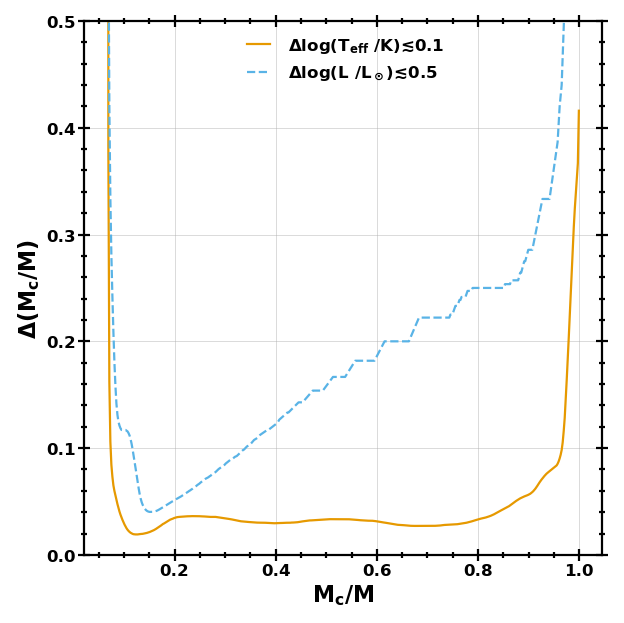

In [102]:

from functions import calc_core_mass_resolution

delta_target_dict = {'LOG_EFFECTIVE_TEMPERATURE':0.1,'LOG_LUMINOSITY':0.5}
label_dict = {'LOG_RADIUS':r'$\Delta \log (R~/\mathrm{R}_\odot) \lesssim$',
              'LOG_LUMINOSITY':r'$\Delta \log (L~/\mathrm{L}_\odot) \lesssim$',
              'LOG_EFFECTIVE_TEMPERATURE':r'$\Delta\log (T_\mathrm{eff}~/\mathrm{K})\lesssim$',
              }

fig,ax=plt.subplots(1,1,figsize=(8,8),sharex=True)

tp_name = tester.settings[f'{evol_phase}_scalar_input_columns'][1]
df_remapped = tester.remap_data_to_orthogonal_grid(
    df[['MASS',tp_name,'HELIUM_CORE_MASS_FRACTION','LOG_RADIUS','LOG_LUMINOSITY']],
    tp_name,
    "HELIUM_CORE_MASS_FRACTION")

df_remapped['LUMINOSITY'] = 10**(df_remapped['LOG_LUMINOSITY'])
df_remapped['RADIUS'] = 10**(df_remapped['LOG_RADIUS'])
df_remapped = add_Teff(df_remapped)
df_remapped['LOG_EFFECTIVE_TEMPERATURE'] = np.log10(df_remapped['EFFECTIVE_TEMPERATURE'])

for quantity, delta_target in delta_target_dict.items():
    allowed_deta = calc_core_mass_resolution(
        df_remapped[df_remapped['MASS']>0.9],
        tp_name = tp_name,
        q_name = quantity,
        delta_target = delta_target,
        quantile = 0.05
        )

    ax.plot(np.array(allowed_deta.index),(allowed_deta.values),label=label_dict[quantity]+str(delta_target_dict[quantity]))
    
ax.set(ylabel=r'$\Delta (M_\mathrm{c}/M)$')
ax.set_ylim(0.0,0.5)
# ax.set_yscale('log')
ax.set(xlabel='$M_\mathrm{c}/M$')
ax.legend()

fig.tight_layout()
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_Mc_res.jpeg',dpi=200)
plt.show()

353


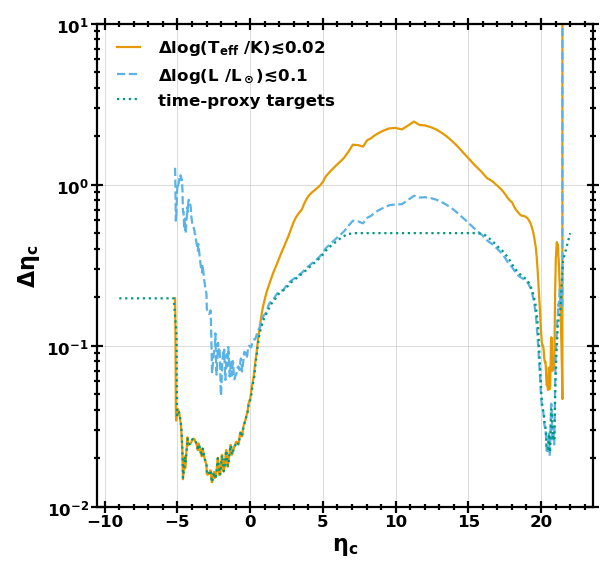

In [101]:
from functions import calc_time_proxy_resolution, get_degen_targets

fig,ax=plt.subplots(1,1,figsize=(8,8))

delta_target_dict = {'LOG_EFFECTIVE_TEMPERATURE':0.02,'LOG_LUMINOSITY':0.1}
label_dict = {'LOG_RADIUS':r'$\Delta \log (R~/\mathrm{R}_\odot) \lesssim$',
              'LOG_LUMINOSITY':r'$\Delta \log (L~/\mathrm{L}_\odot)\lesssim$',
              'LOG_EFFECTIVE_TEMPERATURE':r'$\Delta\log (T_\mathrm{eff}~/\mathrm{K})\lesssim$',
              }

df['LOG_EFFECTIVE_TEMPERATURE'] = np.log10(df['EFFECTIVE_TEMPERATURE'])
df['LOG_LUMINOSITY'] = np.log10(df['LUMINOSITY'])

allowed_deta_list = []

for quantity, delta_target in delta_target_dict.items():

    allowed_deta = calc_time_proxy_resolution(
        df=df[(df['MASS']==df['INITIAL_MASS'])],
        q_name = quantity,
        delta_target=delta_target
        )
    allowed_deta_list += [allowed_deta]
    ax.plot(allowed_deta.index,(allowed_deta.values),label=label_dict[quantity]+f'{delta_target}')

allowed_deta = pd.concat(allowed_deta_list, axis=1).min(axis=1)
targets = get_degen_targets(
    evol_phase=evol_phase, 
    allowed_deta = allowed_deta, 
    first_target = -9.0, 
    max_allowed_deta = 0.5
    )
ax.plot(targets,(np.gradient(targets)),label='time-proxy targets')

ax.set_yscale('log')


ax.set_ylim(0.01,10)
ax.legend(frameon=False)
ax.set(xlabel=r'$\eta_\mathrm{c}$',ylabel=r'$\Delta \eta_\mathrm{c}$')

plt.savefig(f'plots/Z{metallicity}_{evol_phase}_degen_res.jpeg',dpi=200)
plt.show()

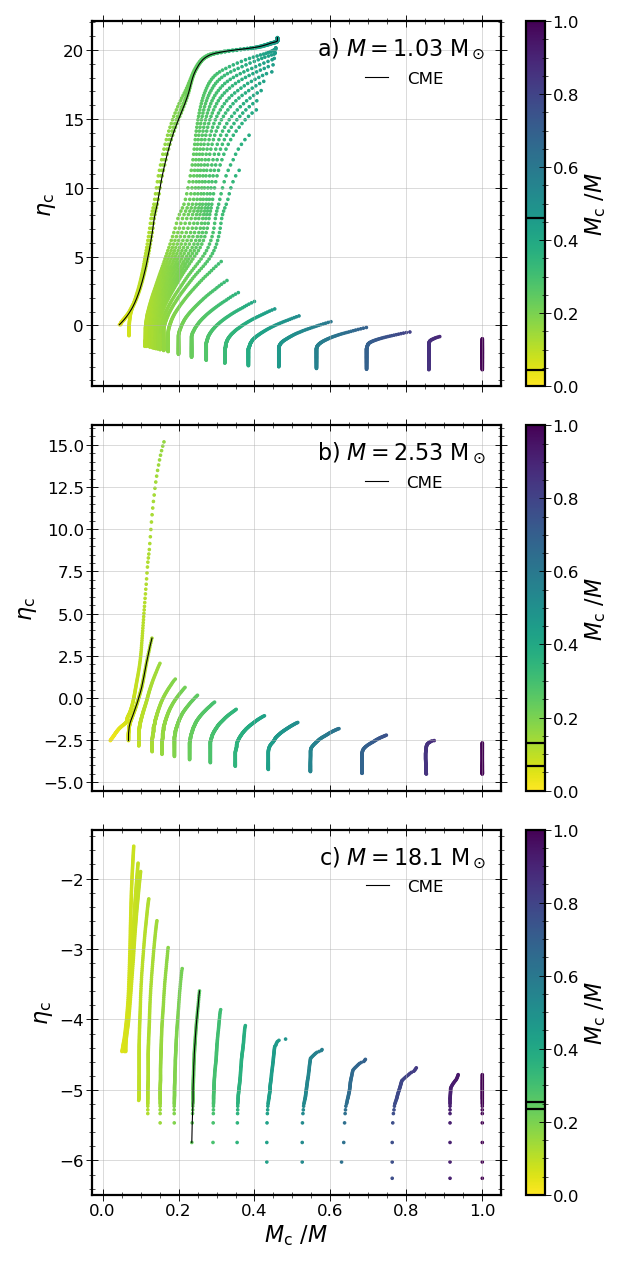

In [244]:
masses = [1.03,2.53,18.1]
fig,ax=plt.subplots(3,1,figsize=(8,16),sharex=True,sharey=False)
axs = ax.flatten()
labels = ['a','b','c']

for i, mass in enumerate(masses):
    
    df_mass = df[df['MASS']==mass]
    sc = axs[i].scatter((df_mass['HELIUM_CORE_MASS_FRACTION']),(df_mass['CENTRAL_DEGENERACY']),c=df_mass['HELIUM_CORE_MASS_FRACTION'],s=5,cmap=cmap.reversed(),vmin=0.0,vmax=1)

    df_sse_mass = df_sse[df_sse['MASS']==mass]
    axs[i].plot(df_sse_mass['HELIUM_CORE_MASS_FRACTION'],(df_sse_mass['CENTRAL_DEGENERACY']),c='black',ls='-',label='CME',linewidth=1)

    axs[i].legend(title=f'{labels[i]}) $M={mass}$'+'$~\mathrm{M}_\odot$',frameon=False)

    cbar = plt.colorbar(sc,ax=axs[i],location='right',label='$M_\mathrm{c}~/M$')
    cbar.ax.hlines(df_sse_mass['HELIUM_CORE_MASS_FRACTION'].min(), 0, 1, colors = 'black', linewidth = 2, linestyles = '-')
    cbar.ax.hlines(df_sse_mass['HELIUM_CORE_MASS_FRACTION'].max(), 0, 1, colors = 'black', linewidth = 2, linestyles = '-')


    axs[i].set(ylabel='$\eta_\mathrm{c}$')

ax[-1].set(xlabel='$M_\mathrm{c}~/M$')

fig.tight_layout()
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_tracks.jpeg',dpi=200)
plt.show()

In [313]:
min_core_mass_he_ignition = df[df['HELIUM_IGNITED_FLAG']==1]['HELIUM_CORE_MASS'].min()
min_degen_he_flash = df[(df['HELIUM_IGNITED_FLAG']==1) & (df['HELIUM_CORE_MASS']==min_core_mass_he_ignition)]['CENTRAL_DEGENERACY'].values[0]
print('Transition degeneracy for he-flash = ', min_degen_he_flash)
he_flash_condition = df.groupby(['MASS', 'INITIAL_MASS'])['CENTRAL_DEGENERACY'].transform('max') > min_degen_he_flash
df_he_flash = df[he_flash_condition]

tables = {
    'he_flash':df_he_flash,
    'no_he_flash': df[~he_flash_condition]#[df[~he_flash_condition]['HELIUM_CORE_MASS']>=TAMS_condition]
    }
tables['he_flash']['MASS'].unique()

Transition degeneracy for he-flash =  4.749


array([0.33, 0.38, 0.43, 0.48, 0.53, 0.63, 0.73, 0.83, 0.93, 1.03, 1.18,
       1.33, 1.48, 1.63, 1.83, 2.03, 2.28, 2.53])

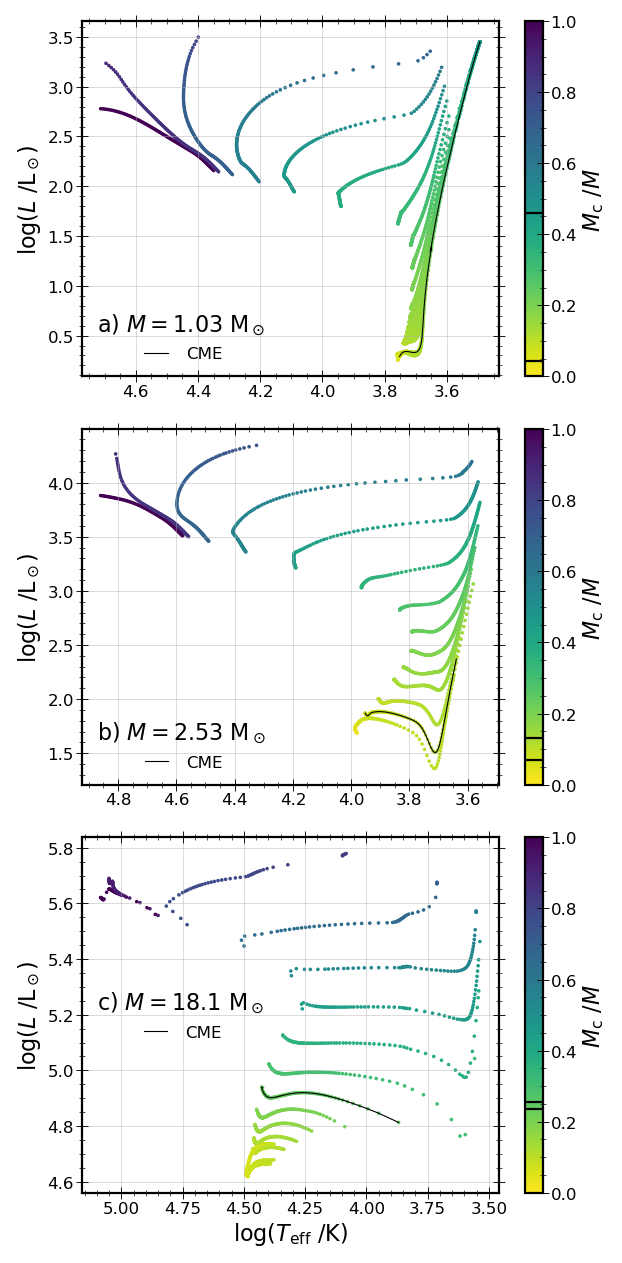

In [188]:
masses = [1.03,2.53,18.1]
fig,ax=plt.subplots(3,1,figsize=(8,16),sharex=False,sharey=False)
axs = ax.flatten()
labels = ['a','b','c']

for i, mass in enumerate(masses):
    
    df_mass = df[df['MASS']==mass]
    sc = axs[i].scatter(np.log10(df_mass['EFFECTIVE_TEMPERATURE']),np.log10(df_mass['LUMINOSITY']),c=df_mass['HELIUM_CORE_MASS_FRACTION'],s=5,cmap=cmap.reversed(),vmin=0.0,vmax=1)

    df_sse_mass = df_sse[df_sse['MASS']==mass]
    axs[i].plot(np.log10(df_sse_mass['EFFECTIVE_TEMPERATURE']),np.log10(df_sse_mass['LUMINOSITY']),c='black',ls='-',label='CME',linewidth=1)

    axs[i].legend(title=f'{labels[i]}) $M={mass}$'+'$~\mathrm{M}_\odot$',frameon=False)

    cbar = plt.colorbar(sc,ax=axs[i],location='right',label='$M_\mathrm{c}~/M$')
    cbar.ax.hlines(df_sse_mass['HELIUM_CORE_MASS_FRACTION'].min(), 0, 1, colors = 'black', linewidth = 2, linestyles = '-')
    cbar.ax.hlines(df_sse_mass['HELIUM_CORE_MASS_FRACTION'].max(), 0, 1, colors = 'black', linewidth = 2, linestyles = '-')

    axs[i].invert_xaxis()
    axs[i].set(ylabel='$\log (L~/\mathrm{L}_\odot)$')

ax[-1].set(xlabel='$\log (T_\mathrm{eff}~/\mathrm{K})$')

fig.tight_layout()
# plt.savefig(f'plots/Z{metallicity}_{evol_phase}_HR.jpeg',dpi=200)
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


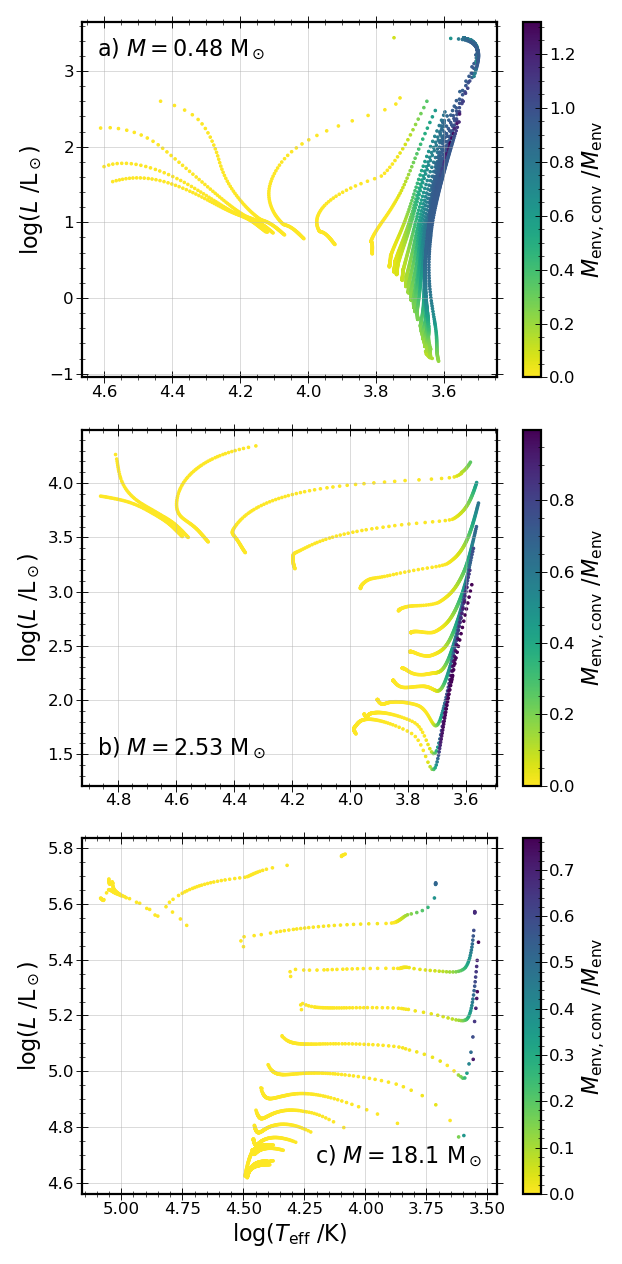

In [186]:
masses = [0.48,2.53,18.1]

fig,ax=plt.subplots(3,1,figsize=(8,16),sharex=False,sharey=False)
axs = ax.flatten()

for i, mass in enumerate(masses):
    
    df_mass = df[df['MASS']==mass]
    sc = axs[i].scatter(np.log10(df_mass['EFFECTIVE_TEMPERATURE']),np.log10(df_mass['LUMINOSITY']),c=df_mass['f_conv'],s=5,cmap=cmap.reversed())

    axs[i].legend(title=f'{labels[i]}) $M={mass}$'+'$~\mathrm{M}_\odot$',frameon=False)

    cbar = plt.colorbar(sc,ax=axs[i],location='right',label='$M_\mathrm{env,conv}~/M_\mathrm{env}$')

    axs[i].invert_xaxis()

# ax[1].yaxis.set_ticks_position("right")
    axs[i].set(ylabel='$\log (L~/\mathrm{L}_\odot)$')

ax[-1].set(xlabel='$\log (T_\mathrm{eff}~/\mathrm{K})$')

fig.tight_layout()
# plt.savefig(f'plots/Z{metallicity}_{evol_phase}_HR_conv_env.jpeg',dpi=200)
plt.show()

[-7.40461493 -0.09689615  4.19443737]
[-0.87764715  2.79662287  3.58885872]


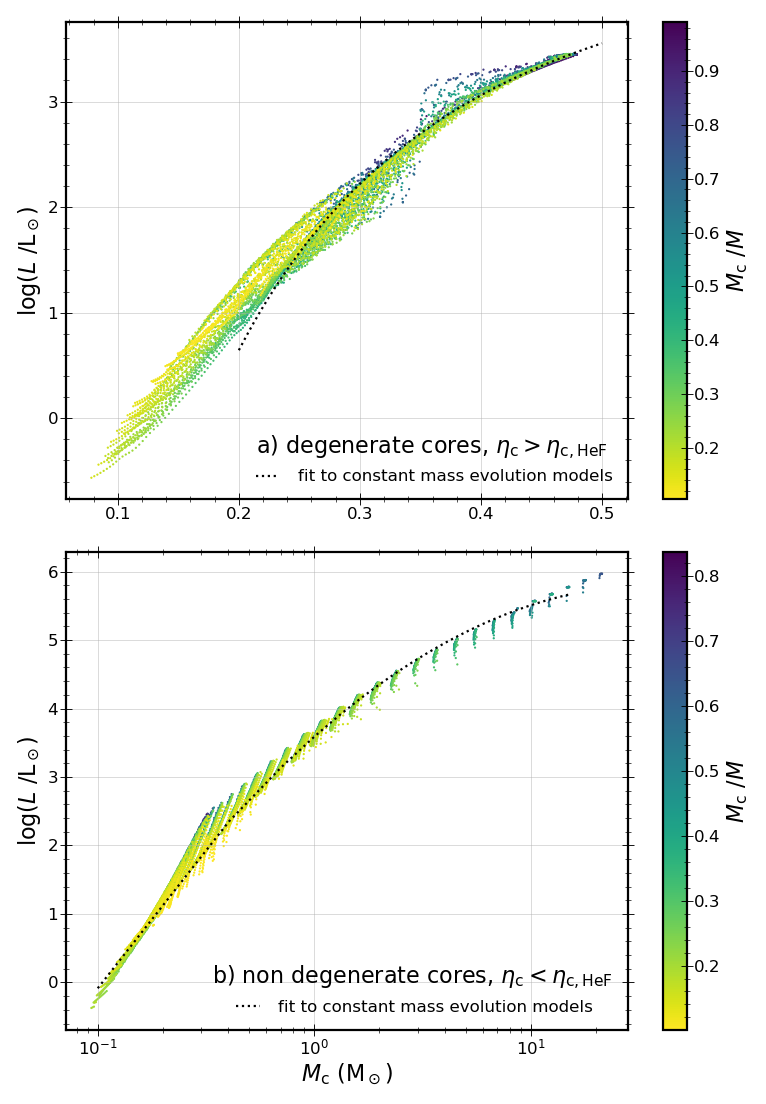

In [234]:
df_FGB = df[df['f_conv']>0.4]
split_condition = df_FGB['CENTRAL_DEGENERACY']>5
df_sse_degen = df_sse[(df_sse['CENTRAL_DEGENERACY']>10)&(df_sse['f_conv']>0.4)]
df_FGB_degen = df_FGB[split_condition]
df_FGB_non_degen = df_FGB[~split_condition]
df_sse_non_degen = df_sse[(df_sse['CENTRAL_DEGENERACY']<5)&(df_sse['f_conv']>0.4)]


degen_fit_params = np.polyfit(
    np.log10(df_sse_degen[df_sse_degen['CENTRAL_DEGENERACY']>20]['HELIUM_CORE_MASS'].values),
    np.log10(df_sse_degen[df_sse_degen['CENTRAL_DEGENERACY']>20]['LUMINOSITY'].values),
    2
)
print(degen_fit_params)
p_degen = np.poly1d(degen_fit_params)

non_degen_fit_params = np.polyfit(
    np.log10(df_sse_non_degen['HELIUM_CORE_MASS'].values),
    np.log10(df_sse_non_degen['LUMINOSITY'].values),
    2
)
print(non_degen_fit_params)
p_non_degen = np.poly1d(non_degen_fit_params)

fig,ax=plt.subplots(2,1,figsize=(10,14),sharex=False)

sc = ax[0].scatter(df_FGB_degen['HELIUM_CORE_MASS'],np.log10(df_FGB_degen['LUMINOSITY']),c=df_FGB_degen['HELIUM_CORE_MASS_FRACTION'],s=1,cmap=cmap.reversed())
cbar = plt.colorbar(sc,ax=ax[0],location='right',label=r'$M_\mathrm{c}~/M$')
x = np.log10(np.linspace(0.2,0.5))
ax[0].plot(10**x,p_degen(x),c='black',ls = ':',label='fit to constant mass evolution models')
# ax[0].plot(10**lum_non_degen_fit_x,lum_non_degen_fit_y,c='black',label = 'non degenerate core')

sc = ax[1].scatter(df_FGB_non_degen['HELIUM_CORE_MASS'],np.log10(df_FGB_non_degen['LUMINOSITY']),c=df_FGB_non_degen['HELIUM_CORE_MASS_FRACTION'],s=1,cmap=cmap.reversed())
cbar = plt.colorbar(sc,ax=ax[1],location='right',label=r'$M_\mathrm{c}~/M$')
x = np.log10(np.linspace(0.1,15))
ax[1].plot(10**x,p_non_degen(x),c='black',ls = ':',label='fit to constant mass evolution models')

# ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].legend(title =r'a) degenerate cores, $\eta_\mathrm{c} > \eta_\mathrm{c,HeF}$',frameon=False)
ax[1].legend(title =r'b) non degenerate cores, $\eta_\mathrm{c} < \eta_\mathrm{c,HeF}$',frameon=False)

ax[0].set(ylabel='$\log(L~/\mathrm{L}_\odot)$')
ax[1].set(ylabel='$\log(L~/\mathrm{L}_\odot)$')
ax[1].set(xlabel='$M_\mathrm{c}~(\mathrm{M}_\odot)$')

fig.tight_layout()
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_lum_Mc_relation.jpeg',dpi=200)
plt.show()

In [92]:
sc = ax[1].scatter(df_he_ign['HELIUM_CORE_MASS'],np.log10(df_he_ign['LUMINOSITY']),c=df_he_ign['HELIUM_CORE_MASS_FRACTION'],cmap=cmap.reversed())
cbar = plt.colorbar(sc,ax=ax[1],location='right',label=r'$M_\mathrm{c}~/M$')

array([-0.0558509 , -0.0476534 , -0.04251374, ...,  0.03058359,
        0.02621071,  0.02661055])

(7195,)

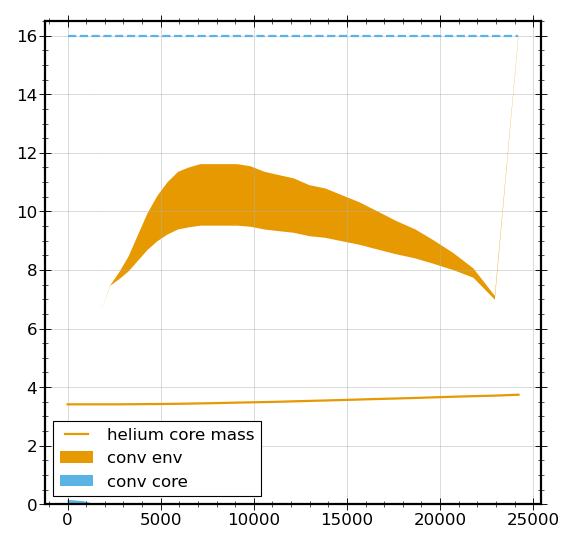

In [171]:
track = df[(df['MASS']==16)&(df['INITIAL_MASS']==16)]

fig,ax=plt.subplots(figsize=(8,8))
ax.plot(track['AGE'],track['HELIUM_CORE_MASS'],label='helium core mass')
ax.plot(track['AGE'],track['MASS'])
top_conv_env = track['CONVECTIVE_ENVELOPE_MASS_TOP_FRACTION']*track['MASS']
bot_conv_env = (track['CONVECTIVE_ENVELOPE_MASS_TOP_FRACTION']+track['CONVECTIVE_ENVELOPE_MASS_FRACTION'])*track['MASS']
top_conv_core = track['CONVECTIVE_CORE_MASS_FRACTION']
ax.fill_between(track['AGE'], bot_conv_env, top_conv_env, label='conv env')
ax.fill_between(track['AGE'], 0, top_conv_core, label = 'conv core')
ax.set_ylim(0,16.5)
ax.legend()
# ax.plot(track['AGE'],track['HYDROGEN_EXHUASTED_CORE_MASS_FRACTION'].values*track['MASS'].values)

0.30741799999999997 5.03


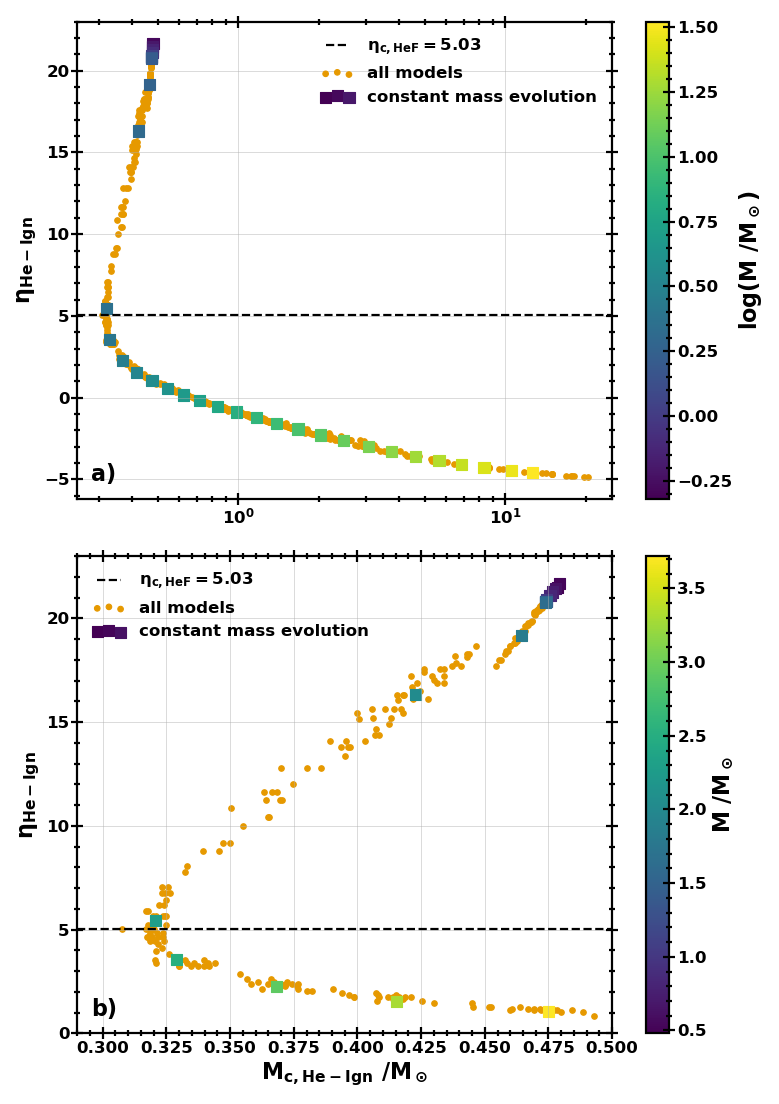

In [29]:
track_includes_tams_condition = df.groupby(['MASS', 'INITIAL_MASS'])['CENTRAL_HYDROGEN'].transform('max') > 1e-6
df_complete_tracks = df[track_includes_tams_condition].copy()

df_ign = df_complete_tracks[df_complete_tracks['HELIUM_IGNITED_FLAG']==1]
df_sse_ign = df_sse[df_sse['HELIUM_IGNITED_FLAG']==1]

min_core_mass_he_ignition = df_ign['HELIUM_CORE_MASS'].min()
min_degen_he_flash = df_ign[df_ign['HELIUM_CORE_MASS']==min_core_mass_he_ignition]['CENTRAL_DEGENERACY'].values[0]
print(min_core_mass_he_ignition,min_degen_he_flash)

degen_branch = df_ign[df_ign['CENTRAL_DEGENERACY']>=min_degen_he_flash]
# params_degen_branch, degen_branch_x, degen_branch_y = fit_polynomial(degen_branch['HELIUM_CORE_MASS'],degen_branch['CENTRAL_DEGENERACY'],order=1)

non_degen_branch = df_ign[df_ign['CENTRAL_DEGENERACY']<min_degen_he_flash]
# params_non_degen_branch, non_degen_branch_x, non_degen_branch_y = fit_polynomial(np.log10(non_degen_branch['HELIUM_CORE_MASS']),non_degen_branch['CENTRAL_DEGENERACY'],order=2)


fig,ax=plt.subplots(2,1,figsize=(10,14),sharey=False)

ax[0].scatter(df_ign['HELIUM_CORE_MASS_FRACTION']*df_ign['MASS'],df_ign['CENTRAL_DEGENERACY'],label='all models')
sc1 = ax[0].scatter(df_sse_ign['HELIUM_CORE_MASS_FRACTION']*df_sse_ign['MASS'],df_sse_ign['CENTRAL_DEGENERACY'],c=np.log10(df_sse_ign['MASS']),label='constant mass evolution',s=100,marker='s')
cbar = plt.colorbar(sc1,ax=ax[0],location='right',label='$\log(M~/\mathrm{M}_\odot)$')
# ax[0].plot(10**non_degen_branch_x,non_degen_branch_y,label='fit')

ax[1].scatter(df_ign['HELIUM_CORE_MASS_FRACTION']*df_ign['MASS'],df_ign['CENTRAL_DEGENERACY'],label='all models')
df_sse_ign = df_sse_ign[df_sse_ign['MASS']<4.0]
sc2 = ax[1].scatter(df_sse_ign['HELIUM_CORE_MASS_FRACTION']*df_sse_ign['MASS'],df_sse_ign['CENTRAL_DEGENERACY'],c=df_sse_ign['MASS'],label='constant mass evolution',s=100,marker='s')
cbar = plt.colorbar(sc2,ax=ax[1],location='right',label='$M~/\mathrm{M}_\odot$')
# ax[1].plot(degen_branch_x,degen_branch_y,label='fit')

ax[0].set_xscale('log')
ax[1].set_ylim(0,23)
ax[1].set_xlim(0.29,0.5)
ax[0].set(ylabel='$\eta_\mathrm{He-Ign}$')
ax[1].set(xlabel='$M_\mathrm{c, He-Ign}~/\mathrm{M}_\odot$',ylabel='$\eta_\mathrm{He-Ign}$')
ax[0].axhline(min_degen_he_flash,c='black',ls='--',label=r'$\eta_\mathrm{c,HeF} = $'+str(min_degen_he_flash))
ax[1].axhline(min_degen_he_flash,c='black',ls='--',label=r'$\eta_\mathrm{c,HeF} = $'+str(min_degen_he_flash))
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)

ax[0].text(0.05, 0.05, 'a)', horizontalalignment='center',
     verticalalignment='center', transform=ax[0].transAxes)
ax[1].text(0.05, 0.05, 'b)', horizontalalignment='center',
     verticalalignment='center', transform=ax[1].transAxes)

fig.tight_layout()
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_He_ign.jpeg',dpi=200)
plt.show()

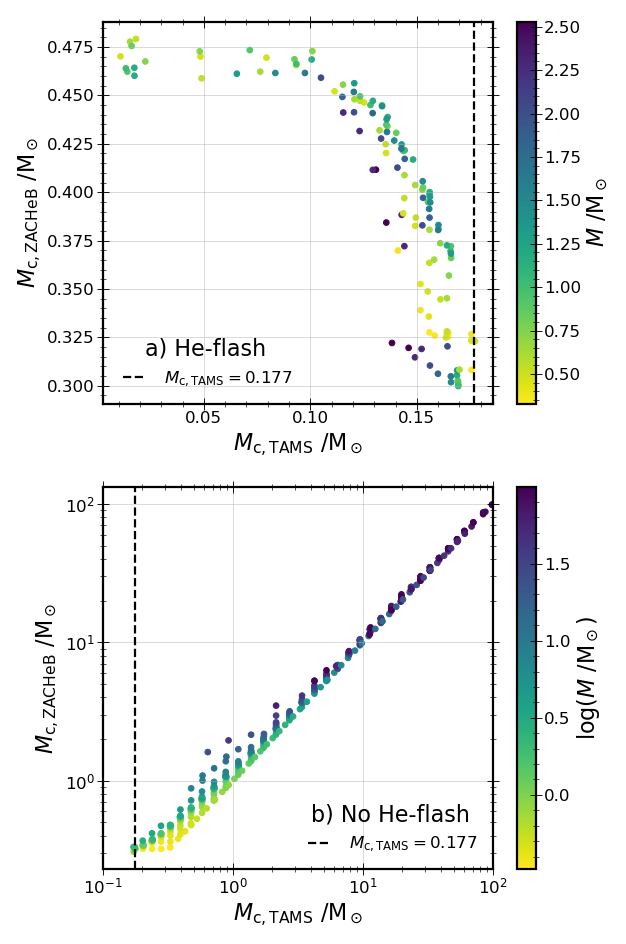

In [429]:
def get_initial_core_mass(x):
    return (x['MASS']*x['HELIUM_CORE_MASS_FRACTION']).min()

def get_final_core_mass(x):
    return (x['MASS']*x['HELIUM_CORE_MASS_FRACTION']).max()

def determine_degen(x,min_degen_he_flash):
    if x['CENTRAL_DEGENERACY'].max()>=min_degen_he_flash:
        return 1
    else:
        return 0
    
track_includes_tams_condition = df.groupby(['MASS', 'INITIAL_MASS'])['CENTRAL_HYDROGEN'].transform('max') > 1e-6
df_complete_tracks = df[track_includes_tams_condition].copy()
    
min_core_mass_he_ignition = df[df['HELIUM_IGNITED_FLAG']==1]['HELIUM_CORE_MASS'].min()
min_degen_he_flash = df[(df['HELIUM_IGNITED_FLAG']==1) & (df['HELIUM_CORE_MASS']==min_core_mass_he_ignition)]['CENTRAL_DEGENERACY'].values[0]

TAMS_Mc = df_complete_tracks.groupby(['INITIAL_MASS','MASS']).apply(lambda x: get_initial_core_mass(x))
ZACHeB_Mc = df_complete_tracks.groupby(['INITIAL_MASS','MASS']).apply(lambda x: get_final_core_mass(x))
M = df_complete_tracks.groupby(['INITIAL_MASS','MASS']).apply(lambda x: x['MASS'].unique()[0])
degen = df_complete_tracks.groupby(['INITIAL_MASS','MASS']).apply(lambda x: determine_degen(x,min_degen_he_flash))

fig,ax=plt.subplots(2,1,figsize=(8,12))
sc1=ax[0].scatter(TAMS_Mc[degen==1].values,ZACHeB_Mc[degen==1].values,c=M[degen==1].values,cmap=cmap.reversed())
sc2=ax[1].scatter(TAMS_Mc[degen==0].values,ZACHeB_Mc[degen==0].values,c=np.log10(M[degen==0].values),cmap=cmap.reversed())
ax[0].set(xlabel='$M_\mathrm{c, TAMS}~/\mathrm{M}_\odot$',ylabel='$M_\mathrm{c, ZACHeB}~/\mathrm{M}_\odot$')
ax[1].set(xlabel='$M_\mathrm{c, TAMS}~/\mathrm{M}_\odot$',ylabel='$M_\mathrm{c, ZACHeB}~/\mathrm{M}_\odot$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

transition_mass = round(TAMS_Mc[degen==1].max(),3)
ax[0].axvline(transition_mass,c='black',ls='--',label='$M_\mathrm{c, TAMS}=$'+f'{transition_mass}')
ax[1].axvline(transition_mass,c='black',ls='--',label='$M_\mathrm{c, TAMS}=$'+f'{transition_mass}')
# ax.set_xlim(0,1)
# ax.set_ylim(0.3,1)
cbar = plt.colorbar(sc1,ax=ax[0],location='right',label='$M~/\mathrm{M}_\odot$')
fcbar = plt.colorbar(sc2,ax=ax[1],location='right',label='$\log(M~/\mathrm{M}_\odot)$')

ax[1].set_xlim(0.1,100)
ax[0].legend(title='a) He-flash',frameon=False)
ax[1].legend(title='b) No He-flash',frameon=False)
fig.tight_layout()

plt.savefig(f'plots/Z{metallicity}_{evol_phase}_Mc_growth.jpeg',dpi=200)
plt.show()

1.938569756221061


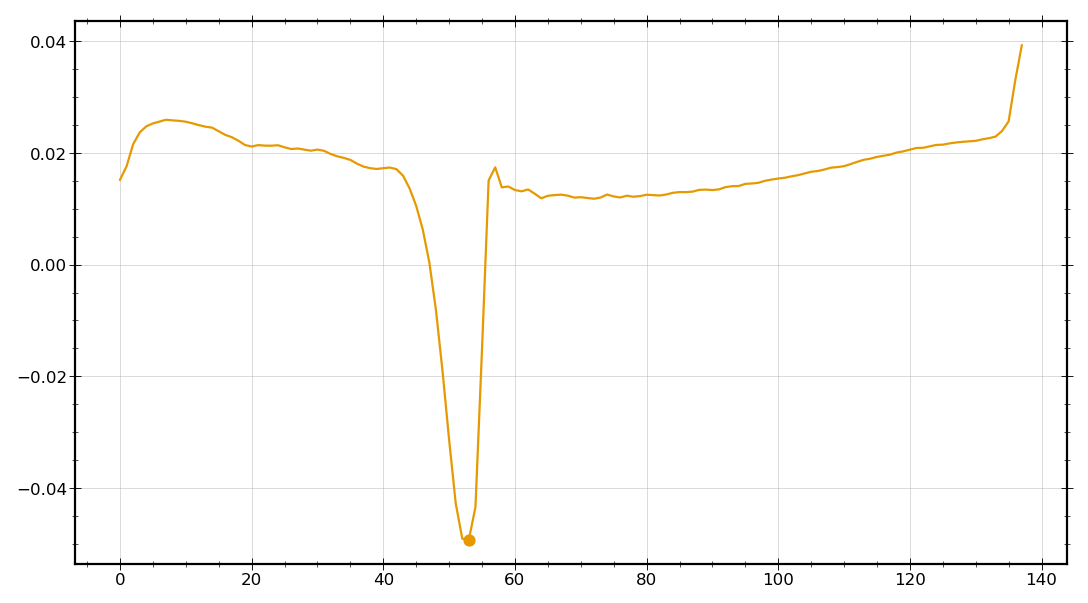

In [177]:
def get_GB(track):
    return np.where((track['f_conv'].values>0.33) & (track['CENTRAL_DEGENERACY'].values>-10) & (track['CENTRAL_DEGENERACY'].values<25))[0]

M = 2.03
Mi = 2.03
track = df[(df['MASS']==M)&(df['INITIAL_MASS']==Mi)]
final_degen = track['CENTRAL_DEGENERACY'].values[-1]
# GB = np.where((track['CENTRAL_DEGENERACY'].values>6)&(track['CENTRAL_DEGENERACY'].values<final_degen-1))[0]
GB = get_GB(track)
if len(GB>1):
    grad_L = np.gradient(np.log10(track['LUMINOSITY'].values[GB]))
    if np.min(grad_L)<0:
        plt.plot(grad_L)
        index_Lbump = np.argmin(np.gradient(np.log10(track['LUMINOSITY'].values[GB])))
        plt.scatter(index_Lbump,grad_L[index_Lbump],s=100)
        L_bump = np.log10(track['LUMINOSITY'].values[GB])[index_Lbump]
        print(L_bump)

0.21
0.215383
1.938569756221061
0.21
0.16694399999999998
1.7630534402996147


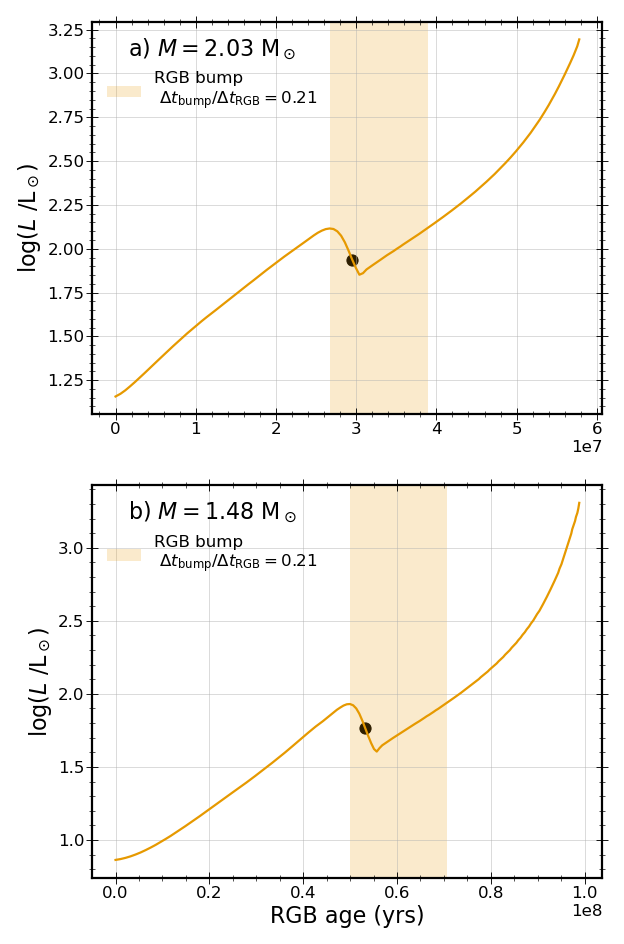

In [9]:
def get_GB(track):
    return np.where((track['f_conv'].values>0.33) & (track['CENTRAL_DEGENERACY'].values>-10) & (track['CENTRAL_DEGENERACY'].values<25))[0]

def time_RGB_bump(track):

    GB = get_GB(track)

    index_Lbump = np.argmin(np.gradient(np.log10(track['LUMINOSITY'].values[GB])))
    start_bump_index = np.argmax(track['LUMINOSITY'].values[GB][:index_Lbump+1])
    end_bump_index = np.where(track['LUMINOSITY'].values[GB][index_Lbump:]>=track['LUMINOSITY'].values[GB][:index_Lbump+1][start_bump_index])[0][0]

    start_bump = (track['AGE'].values[GB][:index_Lbump][start_bump_index],np.log10(track['LUMINOSITY'].values[GB][:index_Lbump][start_bump_index]))
    end_bump = track['AGE'].values[GB][index_Lbump:][end_bump_index],np.log10(track['LUMINOSITY'].values[GB][index_Lbump:][end_bump_index])

    return start_bump, end_bump
    
fig,ax=plt.subplots(2,1,figsize=(8,12))

Mi = 2.03

for i,M in enumerate([2.03,1.48]):

    track = df[(df['MASS']==M)&(df['INITIAL_MASS']==Mi)]
    GB = get_GB(track)
    t0 = track['AGE'].values[GB][0]
    if len(GB)>5:
        grad_L = np.gradient(np.log10(track['LUMINOSITY'].values[GB]))
        if np.min(grad_L)<0:
            index_Lbump = np.argmin(grad_L)
            start_bump, end_bump = time_RGB_bump(track)
            delta_t_bump = round((end_bump[0]-start_bump[0])/(track['AGE'].values[GB][-1]-t0),2)
            ax[i].plot(track['AGE'].values[GB]-t0,np.log10(track['LUMINOSITY'].values[GB]))
            ax[i].scatter(track['AGE'].values[GB][index_Lbump]-t0,np.log10(track['LUMINOSITY'].values[GB][index_Lbump]),c='black',s=100)
            ax[i].axvspan(start_bump[0]-t0,end_bump[0]-t0,alpha=0.2,label='RGB bump\n $\Delta t_\mathrm{bump}/ \Delta t_\mathrm{RGB} = $'+f'${delta_t_bump}$')
            print(delta_t_bump)
            print(track['HELIUM_CORE_MASS'].values[GB][0])
            print(np.log10(track['LUMINOSITY'].values[GB][index_Lbump]))
            ax[i].legend(title=f'{labels[i]}) $M = {M}~$'+'$\mathrm{M}_\odot$',frameon=False)

ax[0].set(ylabel='$\log(L~/\mathrm{L}_\odot)$')
ax[1].set(xlabel='RGB age (yrs)',ylabel='$\log(L~/\mathrm{L}_\odot)$')


fig.tight_layout()
# plt.savefig(f'plots/Z{metallicity}_{evol_phase}_RGB_bump_diagram.jpeg',dpi=200)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

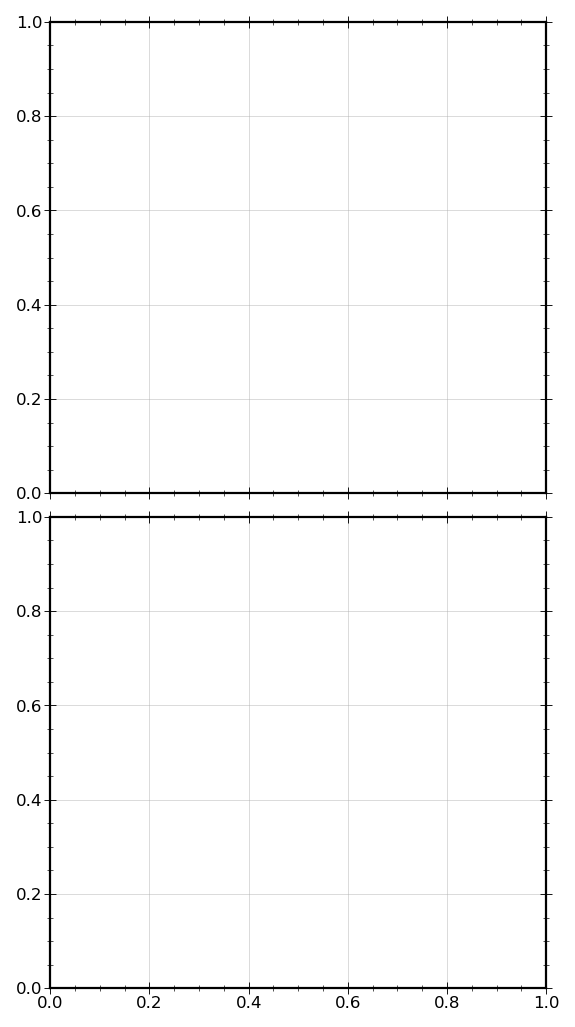

In [10]:
def get_GB(track):
    return np.where((track['f_conv'].values>0.33) & (track['CENTRAL_DEGENERACY'].values>5) & (track['CENTRAL_DEGENERACY'].values<25))[0]

def get_RGB_bump(df):
    L_bump = []
    Mc_bump = []
    M_bump = []
    delta_t_bump = []

    for M in [M for M in df['MASS'].unique() if M>0.1]:
        df_mass = df[df['MASS']==M]
        for Mi in df_mass['INITIAL_MASS'].unique():
            track = df_mass[df_mass['INITIAL_MASS']==Mi]
            GB = get_GB(track)
            if len(GB)>5:
                grad_L = np.gradient(np.log10(track['LUMINOSITY'].values[GB]))
                if np.min(grad_L)<0:
                    index_Lbump = np.argmin(grad_L)
                    L_bump += [np.log10(track['LUMINOSITY'].values[GB])[index_Lbump]]
                    Mc_bump += [track['HELIUM_CORE_MASS'].values[GB][index_Lbump]]
                    M_bump += [M]
                    start_bump, end_bump = time_RGB_bump(track)
                    delta_t_bump += [end_bump[0]-start_bump[0]]
    return L_bump, Mc_bump, M_bump, delta_t_bump

fig,ax=plt.subplots(2,1,figsize=(8,16),sharex=True)

L_bump, Mc_bump, M_bump, delta_t_bump = get_RGB_bump(df)
L_bump_sse, Mc_bump_sse, M_bump_sse, delta_t_bump_sse = get_RGB_bump(df_sse)

sc = ax[0].scatter(L_bump,Mc_bump,label='all')
sc = ax[0].scatter(L_bump_sse,Mc_bump_sse,c=M_bump_sse,cmap=cmap.reversed(),label='SSE',s=100,marker='s')

sc = ax[1].scatter(L_bump,np.log10(delta_t_bump),label='all')
sc = ax[1].scatter(L_bump_sse,np.log10(delta_t_bump_sse),c=M_bump_sse,cmap=cmap.reversed(),label='CME',s=100,marker='s')

ax[0].set(ylabel='$M_\mathrm{c}~/\mathrm{M}_\odot$ (RGB bump)')
ax[1].set(ylabel='$\log(\Delta t~/\mathrm{yrs})$ (RGB bump)',xlabel='$\log(L~/\mathrm{L}_\odot)$ (RGB bump)')
ax[0].set_ylim(0.15,0.35)
ax[0].set_xlim(0.5,2.5)
ax[0].legend(title = 'RGB Bump, a) $M_\mathrm{c}$', frameon=False)
ax[1].legend(title = 'RGB Bump, b) $\Delta t$', frameon=False)
# cbar = plt.colorbar(sc,ax=ax[0],location='top',label='$M~(\mathrm{M}_\odot)$')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
fig.colorbar(sc, cax=cbar_ax,label='$M~(\mathrm{M}_\odot)$')

plt.savefig(f'plots/Z{metallicity}_{evol_phase}_RGB_bump.jpeg',dpi=200)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

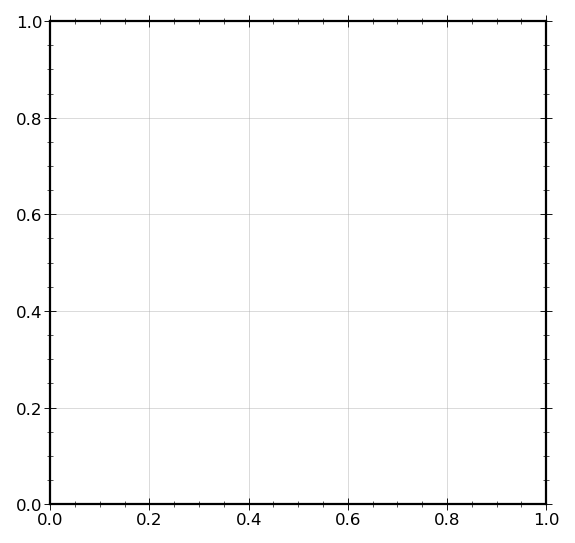

In [12]:

def get_RGB_bump(df):
    L_bump = []
    Mc_bump = []
    M_bump = []
    delta_t_bump = []

    for M in [M for M in df['MASS'].unique() if M>0.1]:
        df_mass = df[df['MASS']==M]
        for Mi in df_mass['INITIAL_MASS'].unique():
            track = df_mass[df_mass['INITIAL_MASS']==Mi]
            GB = get_GB(track)
            if len(GB)>5:
                grad_L = np.gradient(np.log10(track['LUMINOSITY'].values[GB]))
                if np.min(grad_L)<0:
                    index_Lbump = np.argmin(grad_L)
                    L_bump += [np.log10(track['LUMINOSITY'].values[GB])[index_Lbump]]
                    Mc_bump += [track['HELIUM_CORE_MASS'].values[GB][index_Lbump]]
                    M_bump += [M]
                    start_bump, end_bump = time_RGB_bump(track)
                    delta_t_bump += [end_bump[0]-start_bump[0]]
    return L_bump, Mc_bump, M_bump, delta_t_bump

fig,ax=plt.subplots(1,1,figsize=(8,8),sharex=True)

L_bump, Mc_bump, M_bump, delta_t_bump = get_RGB_bump(df)
L_bump_sse, Mc_bump_sse, M_bump_sse, delta_t_bump_sse = get_RGB_bump(df_sse)

ax.scatter(Mc_bump,L_bump,label='all')
sc = ax.scatter(Mc_bump_sse,L_bump_sse,c=M_bump_sse,cmap=cmap.reversed(),label='CME',s=100,marker='s')


ax.set(xlabel='$M_\mathrm{c}~/\mathrm{M}_\odot$ (RGB bump)',ylabel='$\log(L~/\mathrm{L}_\odot)$ (RGB bump)')
ax.set_xlim(0.15,0.35)
ax.set_ylim(0.5,2.5)
ax.legend(title = 'RGB Bump', frameon=False)
# cbar = plt.colorbar(sc,ax=ax[0],location='top',label='$M~(\mathrm{M}_\odot)$')
cbar = plt.colorbar(sc1,ax=ax,location='right',label='$M~(\mathrm{M}_\odot)$')

plt.savefig(f'plots/Z{metallicity}_{evol_phase}_RGB_bump.jpeg',dpi=200)
plt.show()

In [ ]:
table_name = "remapped_tracks_Z%7.2e_%s.csv" %(float(metallicity),evol_phase)
table_filepath = os.path.join(f'/Users/natalierees/MINT_grids_23051/Z{metallicity}/{evol_phase}',table_name)
df_remapped = pd.read_csv(table_filepath,index_col=[0])
df_remapped = add_Teff(df_remapped)
df_remapped.head()

/Users/natalierees/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


MASS  CENTRAL_DEGENERACY  HELIUM_CORE_MASS_FRACTION  RADIUS  LUMINOSITY  \
418   0.13              -7.253                       0.00  0.1076     0.02419   
837   0.13              -7.253                       0.02  0.1076     0.02419   
1256  0.13              -7.253                       0.04  0.1076     0.02419   
1675  0.13              -7.253                       0.06  0.1076     0.02419   
2094  0.13              -7.253                       0.08  0.1076     0.02419   

      LUMINOSITY_DIV_EDDINGTON_LUMINOSITY  NEUTRINO_LUMINOSITY  \
418                              0.000021              0.00115   
837                              0.000021              0.00115   
1256                             0.000021              0.00115   
1675                             0.000021              0.00115   
2094                             0.000021              0.00115   

      HELIUM_LUMINOSITY  AGE  CENTRAL_HYDROGEN  ...  \
418        4.033000e-34  0.0           0.00011  ...   
837        4.033000e-34  0.0           0.00011  ...   
1256       4.033000e-34  0.0           0.00011  ...   
1675       4.033000e-34  0.0           0.00011  ...   
2094       4.033000e-34  0.0           0.00011  ...   

                                      CHEBYSHEV_DENSITY  \
418   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
837   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1256  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1675  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
2094  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   

                               CHEBYSHEV_TOTAL_PRESSURE  \
418   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
837   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1256  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1675  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
2094  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   

                                 CHEBYSHEV_GAS_PRESSURE  \
418   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
837   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1256  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1675  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
2094  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   

                                       CHEBYSHEV_RADIUS  \
418   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
837   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1256  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1675  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
2094  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   

                                       CHEBYSHEV_GAMMA1  \
418   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
837   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1256  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1675  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
2094  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   

                        CHEBYSHEV_PRESSURE_SCALE_HEIGHT  \
418   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
837   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1256  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1675  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
2094  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   

                        CHEBYSHEV_DIFFUSION_COEFFICIENT  \
418   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
837   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1256  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1675  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
2094  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   

                         CHEBYSHEV_HELIUM_MASS_FRACTION  \
418   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
837   [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1256  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
1675  [8.485e-09 2.853e-05 2.566e-04 7.118e-04 1.392...   
2094  [8.48

/var/folders/39/gsrxfrr54nz6rb_qwtfbtvhc0000gn/T/ipykernel_3439/2854995994.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mass['LOG_LUMINOSITY'] = np.log10(df_mass['LUMINOSITY'])
/var/folders/39/gsrxfrr54nz6rb_qwtfbtvhc0000gn/T/ipykernel_3439/2854995994.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mass['LOG_HELIUM_LUMINOSITY'] = np.log10(df_mass['HELIUM_LUMINOSITY'])
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found t

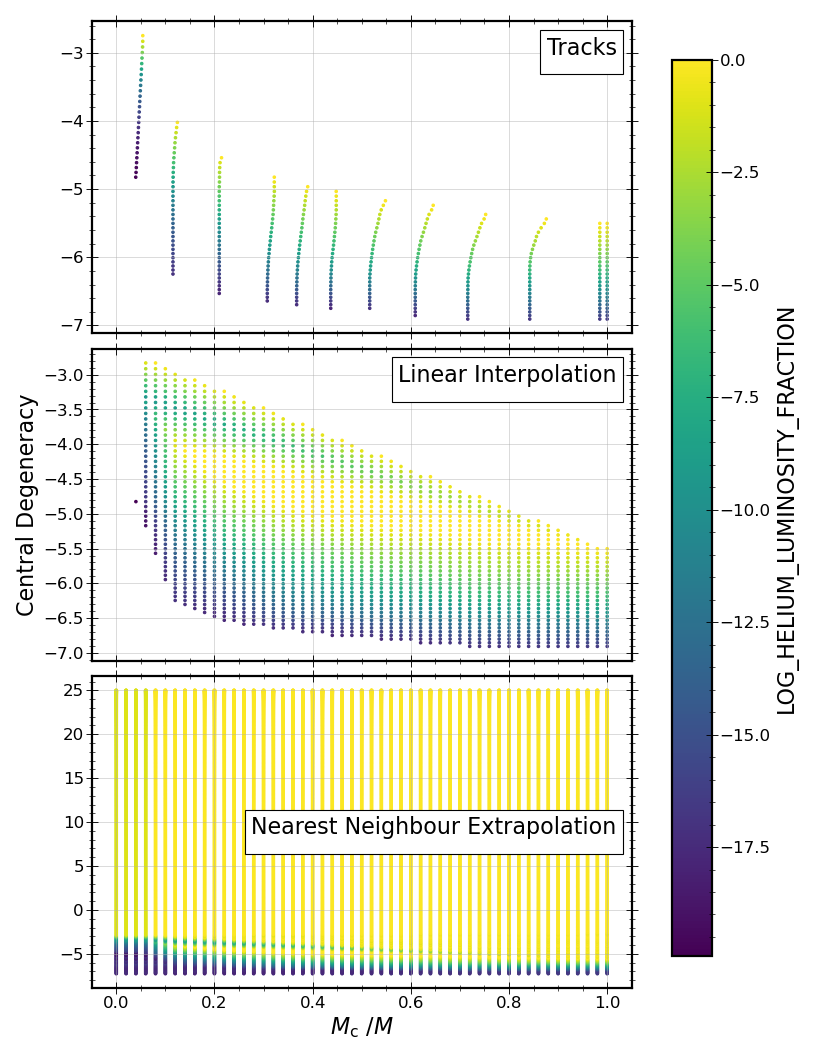

In [434]:
mass = 54
quantity = 'LOG_HELIUM_LUMINOSITY_FRACTION' #'CONVECTIVE_ENVELOPE_MASS_FRACTION'
df_remapped_no_extrapolation = df_remapped[df_remapped['EXTRAPOLATION_FLAG']==0]

fig,ax = plt.subplots(3,1,figsize=(10,16),sharex=True)
for i, df_choice in enumerate([df,df_remapped_no_extrapolation,df_remapped]):
    df_mass = df_choice[df_choice['MASS']==mass]
    df_mass['LOG_LUMINOSITY'] = np.log10(df_mass['LUMINOSITY'])
    df_mass['LOG_HELIUM_LUMINOSITY'] = np.log10(df_mass['HELIUM_LUMINOSITY'])
    im = ax[i].scatter(df_mass['HELIUM_CORE_MASS_FRACTION'],df_mass['CENTRAL_DEGENERACY'],c=df_mass[quantity],s=5)

ax[1].set(ylabel='Central Degeneracy')
ax[2].set(xlabel='$M_\mathrm{c}~/M$')

ax[0].legend(title='Tracks')
ax[1].legend(title='Linear Interpolation',loc='upper right')
ax[2].legend(title='Nearest Neighbour Extrapolation')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax,label=quantity)

plt.savefig(f'plots/Z{metallicity}_{evol_phase}_remapping_{quantity}.jpeg',dpi=200)
plt.show()


In [435]:
# Create a condition
min_core_mass_he_ignition = df[df['HELIUM_IGNITED_FLAG']==1]['HELIUM_CORE_MASS'].min()
min_degen_he_flash = df[(df['HELIUM_IGNITED_FLAG']==1) & (df['HELIUM_CORE_MASS']==min_core_mass_he_ignition)]['CENTRAL_DEGENERACY'].values[0]
print(min_degen_he_flash)
condition = df.groupby(['MASS', 'INITIAL_MASS'])['CENTRAL_DEGENERACY'].transform('max') > min_degen_he_flash

4.749


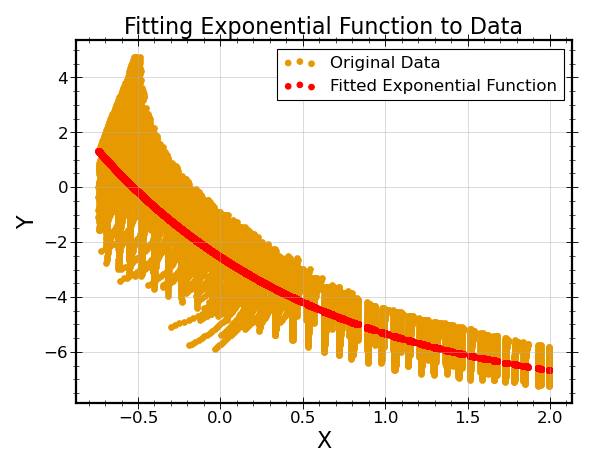

Fitted Parameters:
a = 0.8845417912824644
b = 0.7337263860092137
c = 1.8000555777110516
d = 7.896497182858746


In [440]:
df_ign = df_complete_tracks[(df_complete_tracks['HELIUM_IGNITED_FLAG']==1)&(df_complete_tracks['CENTRAL_DEGENERACY']<5)]
# plt.scatter(df_ign['HELIUM_CORE_MASS'],df_ign['CENTRAL_DEGENERACY'])

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the exponential function
def exponential_function(x, a, b, c, d):
    return a * np.exp(c-b * x)-d

def quadratic_function(x, a, b, c, d):
    return d*x**3 + a * x**2 + b * x + c

# Generate some sample data
x_data = np.log10(df_no_he_flash['HELIUM_CORE_MASS'].values)
# x_data = df_ign['HELIUM_CORE_MASS'].values
y_data = df_no_he_flash['CENTRAL_DEGENERACY'].values

# Fit the exponential function to the data
popt, pcov = curve_fit(exponential_function, x_data, y_data, p0=(1,1,1.3,1))

# Extract the fitted parameters
a_fit, b_fit, c_fit, d_fit = popt

df_no_he_flash['core_degen'] = -(a_fit*np.exp(c_fit-b_fit*x_data)-y_data-d_fit)

# Plot the original data and the fitted exponential function
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, label='Original Data')
plt.scatter(x_data, exponential_function(x_data, a_fit, b_fit, c_fit, d_fit), color='red', label='Fitted Exponential Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting Exponential Function to Data')
plt.legend()
plt.grid(True)
plt.show()

print("Fitted Parameters:")
print("a =", a_fit)
print("b =", b_fit)
print("c =", c_fit)
print("d =", d_fit)


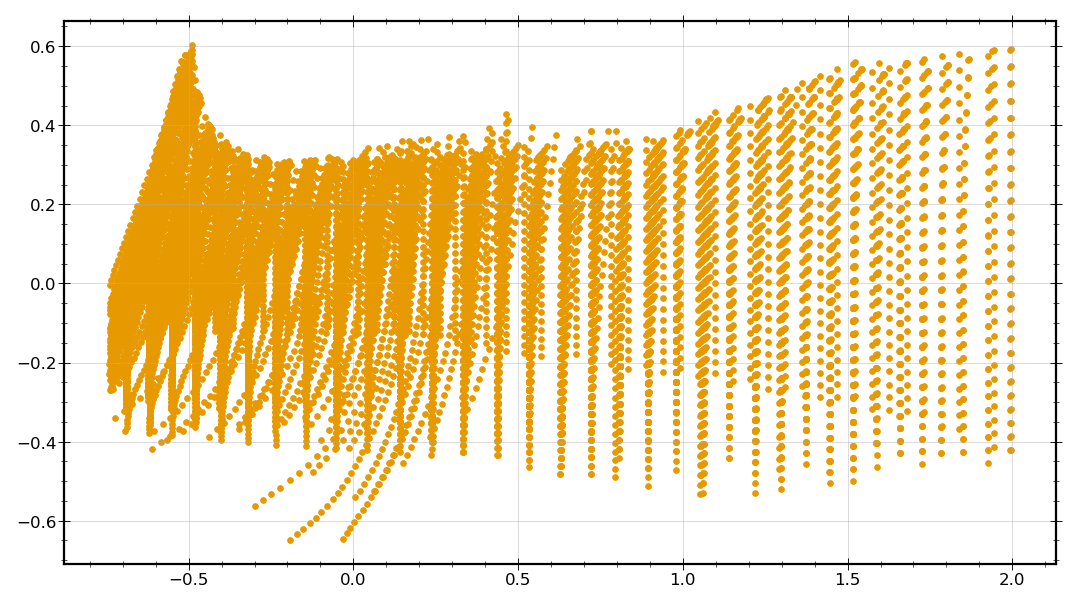

In [444]:
plt.scatter(np.log10(df_no_he_flash['HELIUM_CORE_MASS']),df_no_he_flash['core_degen'])

In [442]:
hist, bin_edges = np.histogram(x_data, bins=10)
degen_range = {}
for i in range(len(bin_edges)-1):
    mask = (np.log10(df_no_he_flash['HELIUM_CORE_MASS']) > bin_edges[i]) & (np.log10(df_no_he_flash['HELIUM_CORE_MASS']) < bin_edges[i+1])
    df_sec = df_no_he_flash[mask]
    degen_range[(bin_edges[i]+bin_edges[i+1])/2] = df_sec['core_degen'].max()-df_sec['core_degen'].min()

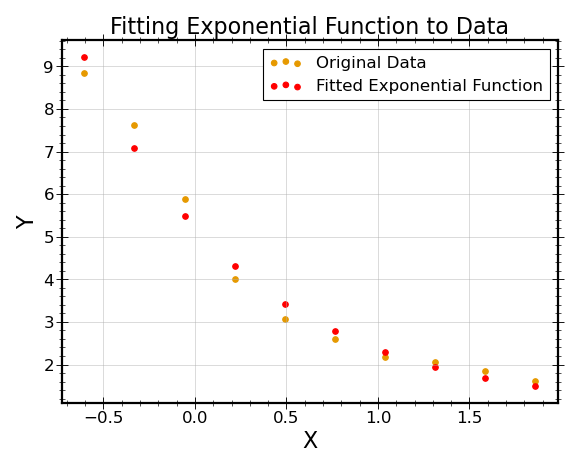

Fitted Parameters:
a = 0.9719187715443983
b = 1.0942549422562653
c = 1.4834316722536827
d = -0.9290134938600478


In [443]:
x_data = np.array(list(degen_range.keys()))
y_data = np.array(list(degen_range.values()))

# Fit the exponential function to the data
popt, pcov = curve_fit(exponential_function, x_data, y_data, p0=(1,1,1.3,1))

# Extract the fitted parameters
a_fit, b_fit, c_fit, d_fit = popt

df_no_he_flash['core_degen'] = df_no_he_flash['core_degen']/exponential_function(np.log10(df_no_he_flash['HELIUM_CORE_MASS']),a_fit, b_fit, c_fit, d_fit )

# Plot the original data and the fitted exponential function
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, label='Original Data')
plt.scatter(x_data, exponential_function(x_data, a_fit, b_fit, c_fit, d_fit), color='red', label='Fitted Exponential Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting Exponential Function to Data')
plt.legend()
plt.grid(True)
plt.show()

print("Fitted Parameters:")
print("a =", a_fit)
print("b =", b_fit)
print("c =", c_fit)
print("d =", d_fit)